# Perceptual-Hashing


Here we'll have a look at the perceptual hashing, as well as a little bit of testing/bug hunting on the already implemented image manipulation methods.

NOTE: If running locally on `mps` can only load one model at a time.

In [3]:
# load image of me
from diffusers.utils import load_image

from arc_phash.image_manipulation.utils import resize_and_crop

turing_img = load_image("../images/turing_img.jpg")
turing_img = resize_and_crop(turing_img)

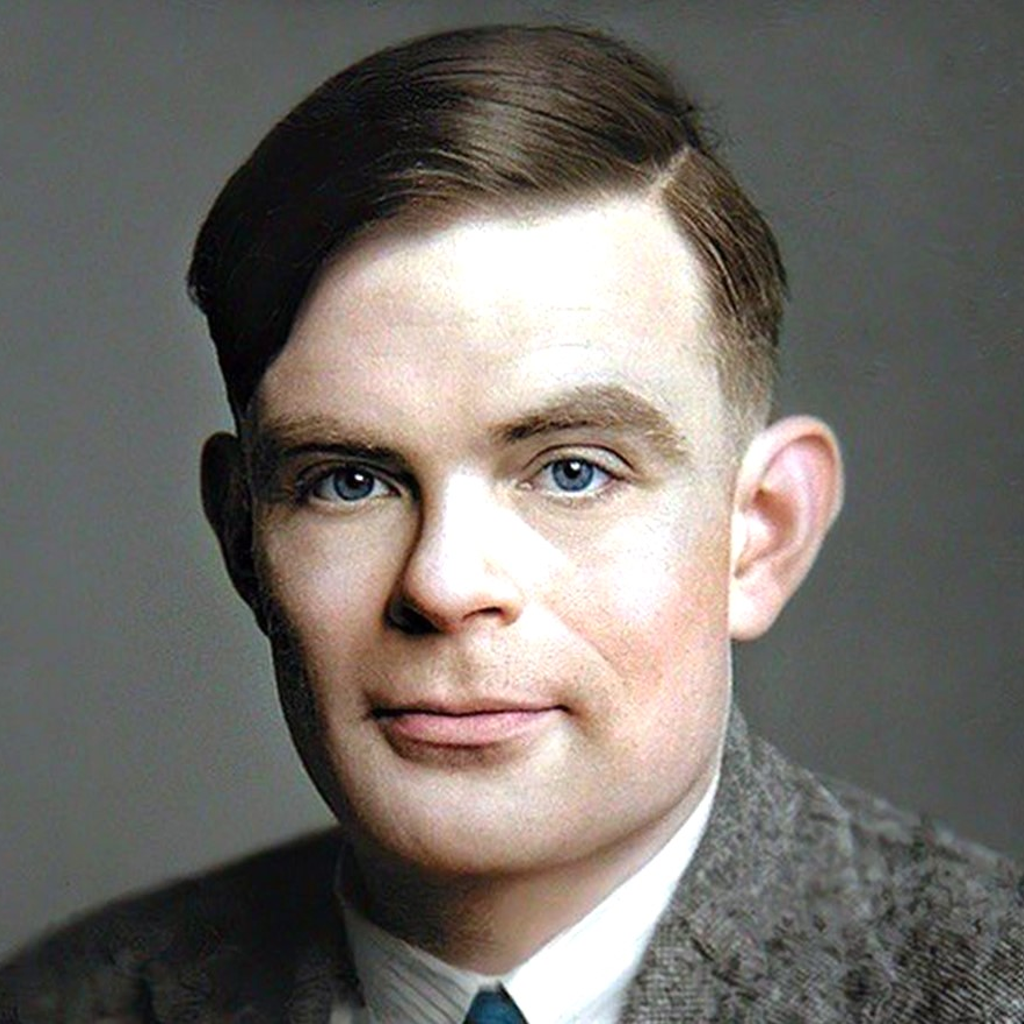

In [4]:
turing_img

In [5]:
# load inpainter
from pprint import pprint

from arc_phash.image_manipulation.deepfake import img2img

inpainter = img2img.Img2Img(device="mps", resize_size=512)
pprint(inpainter.pipe_kwargs)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

{'generator': <torch._C.Generator object at 0x16dd07d30>,
 'guidance_scale': 5.520765158067848,
 'height': 512,
 'max_sequence_length': 256,
 'num_inference_steps': np.int64(19),
 'prompt': 'roam moose The squeamish raisin attains.',
 'strength': 0.2448456035508146,
 'width': 512}


In [16]:
inpainter.generate_img2img(image=turing_img, strength=0.5)

  0%|          | 0/10 [00:00<?, ?it/s]

In [17]:
in_turing = inpainter.get_results()

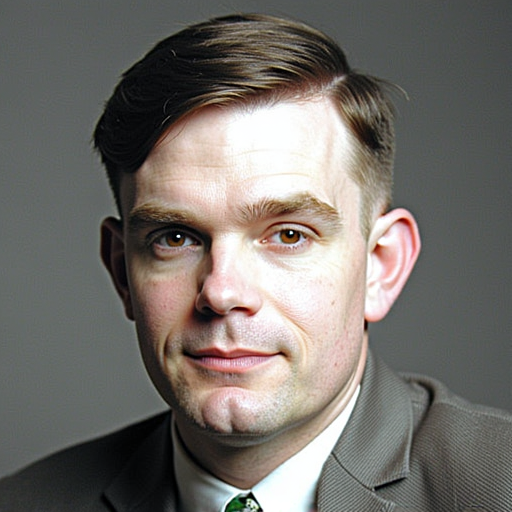

In [ ]:
alt_turing = in_turing[2]["img2img"]
alt_turing

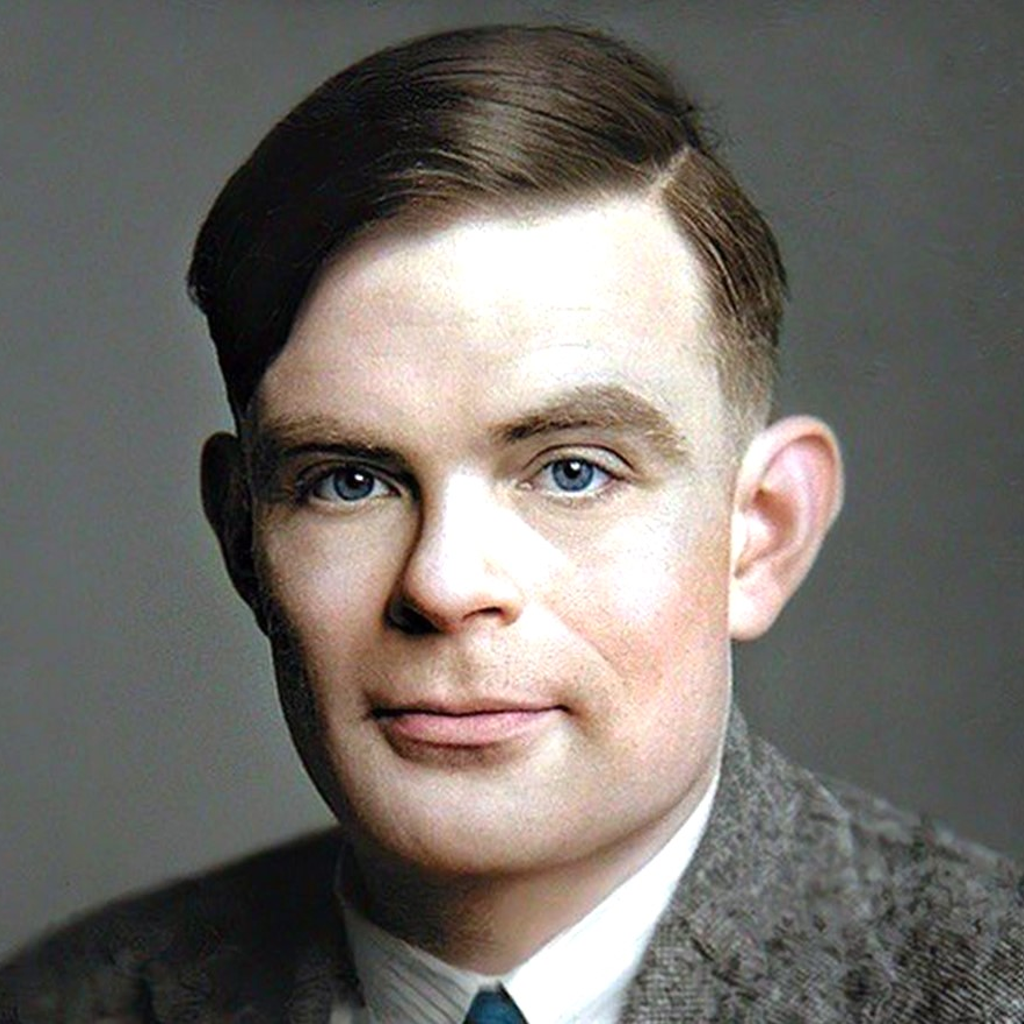

In [22]:
turing_img

In [ ]:
import numpy as np

strengths = np.linspace(0.1, 0.9, 5)

for strength in strengths:
    inpainter.generate_img2img(image=me_img, strength=strength)

In [7]:
out_imgs = inpainter.get_results()

## Perceptual Hashes

Now it appears that the image generation methods work, lets start comapring some perceptual hashes of them.

In [20]:
import numpy as np
import pdqhash

hash_vec_orig, qual_o = pdqhash.compute(np.asarray(turing_img))
hash_vec_alt, qual_a = pdqhash.compute(np.asarray(alt_turing))

In [21]:
from scipy.spatial.distance import euclidean, hamming, sqeuclidean

print("distances from original to original:")
print(f"sqeuclidean: {sqeuclidean(hash_vec_orig, hash_vec_orig)}")
print(f"euclidean: {euclidean(hash_vec_orig, hash_vec_orig)}")
print(f"hamming: {hamming(hash_vec_orig, hash_vec_orig)}")

print("distances from original to inpainted:")
print(f"sqeuclidean: {sqeuclidean(hash_vec_orig, hash_vec_alt)}")
print(f"euclidean: {euclidean(hash_vec_orig, hash_vec_alt)}")
print(f"hamming: {hamming(hash_vec_orig, hash_vec_alt)}")

distances from original to original:
sqeuclidean: 0.0
euclidean: 0.0
hamming: 0.0
distances from original to inpainted:
sqeuclidean: 24.0
euclidean: 4.898979485566356
hamming: 0.09375


In [26]:
import pdqhash


def hash_dist(img_1, img_2):
    """compute hash distance based on pdq hash"""
    hash_1, _ = pdqhash.compute(np.asarray(img_1))
    hash_2, _ = pdqhash.compute(np.asarray(img_2))
    return sqeuclidean(hash_1, hash_2)

In [24]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import sqeuclidean


def plotter(imgs: list):
    """plot images and distances"""
    fig, ax = plt.subplots(1, len(imgs), figsize=(20, 15))
    _ = [ax[idx].imshow(img) for idx, img in enumerate(imgs)]
    _ = [
        ax[idx].set_title(f"{hash_dist(imgs[0], img)}") for idx, img in enumerate(imgs)
    ]
    _ = [axe.axis("off") for axe in ax]
    fig.suptitle("Squared euqlidean distance between PHash of original and infill")
    plt.show()

In [ ]:
images = []
images.append(out_imgs[0]["original"])
for out in out_imgs:
    images.append(out["img2img"])

plotter(images)

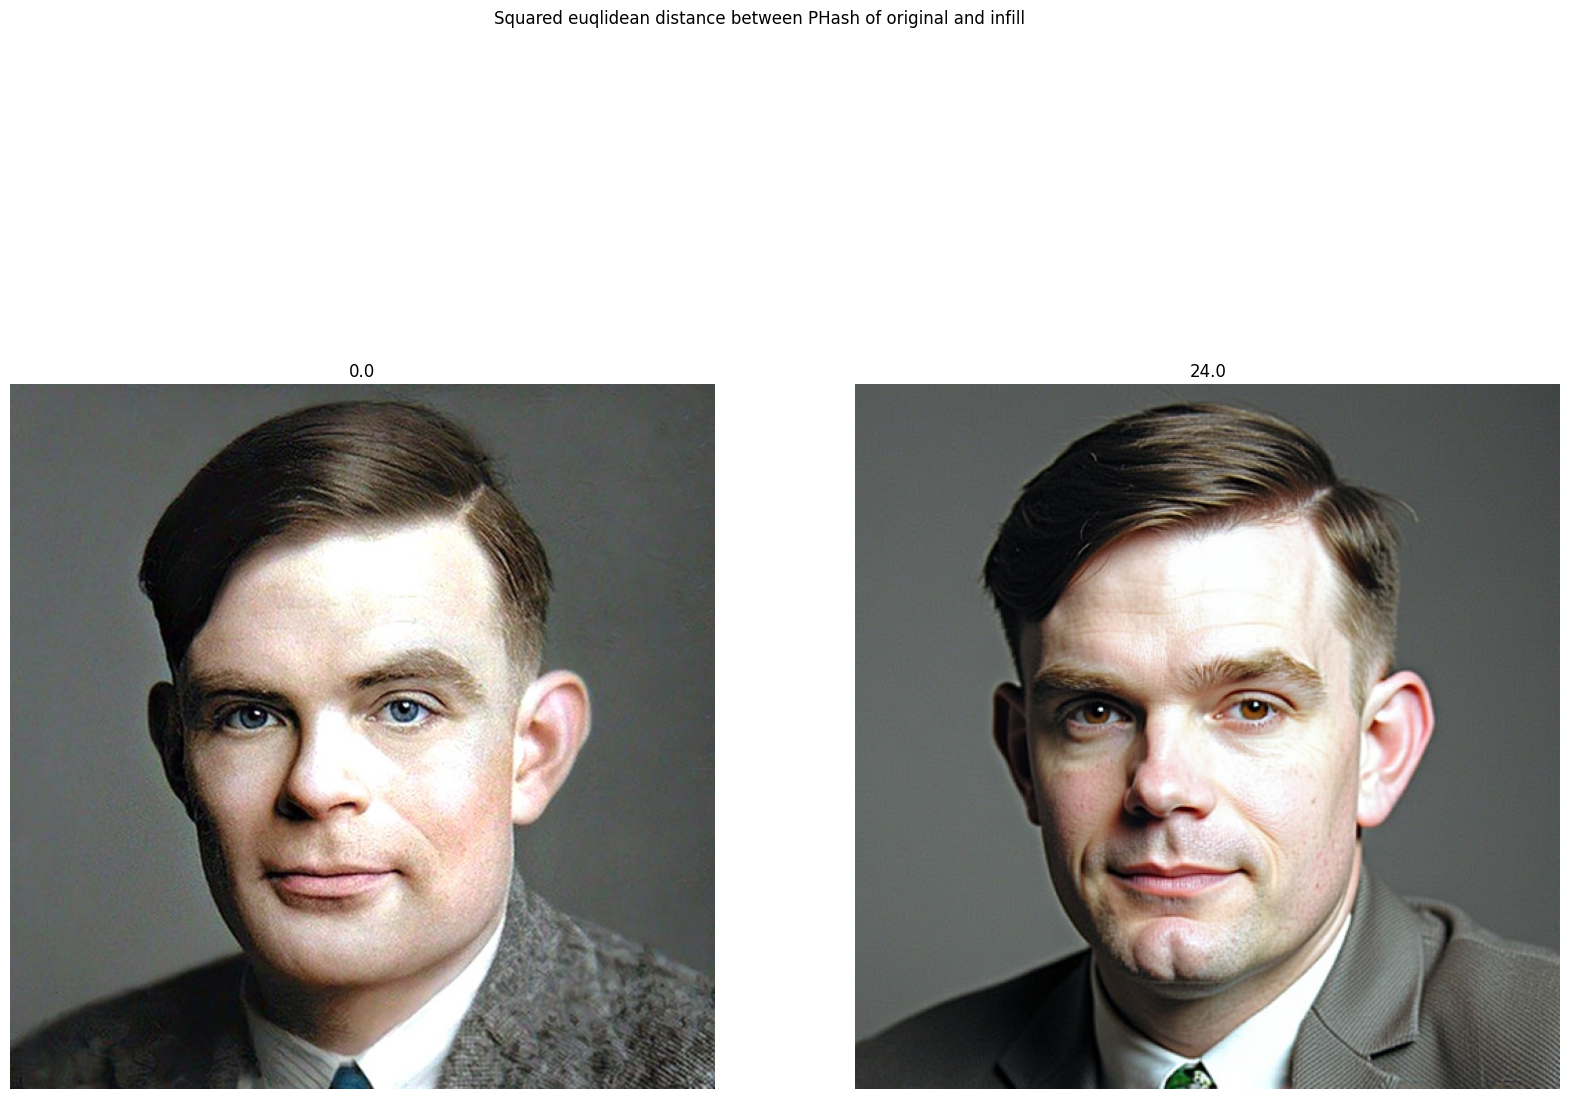

In [ ]:
imgs = inpainter.get_results()
images = [turing_img, imgs[1]["img2img"], alt_turing, imgs[0]["img2img"]]
plotter(images)